# Artificial mental phenomena: Psychophysics as a framework to detect perception biases in AI models

Lizhen Liang and Daniel E. Acuna  
School of Information Studies      
Syracuse University  
Science of Science & Computational Discovery Lab  
Syracuse, New York

## Part 2: Markov Chain Monte Carlo

In [1]:
import os
import findspark

os.environ['PATH'] = os.environ['PATH'] + ":/usr/java/jdk1.8.0_162/bin"

import findspark
os.environ['PYSPARK_SUBMIT_ARGS'] = \
    "--packages com.databricks:spark-xml_2.11:0.5.0 pyspark-shell"
findspark.init('/opt/cloudera/parcels/SPARK2/lib/spark2/')

from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    appName('Bias_part2').\
    config('spark.driver.memory', '10g').\
    config('spark.network.timeout', '600s').\
    config('spark.driver.maxResultSize', '10g').\
    config('spark.executor.memory', '10g').\
    config('spark.kryoserializer.buffer.max', '1g').getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [22]:
import torch
import torch.nn as nn

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [60]:
import pyro
from numpy.random import uniform
from scipy.stats import norm
from scipy.stats import ttest_1samp
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.abstract_infer import EmpiricalMarginal
from pyro.distributions import Bernoulli, Normal

## Detecting bias using MCMC

### Implementing MLP

In [5]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import RegexTokenizer

In [6]:
imdb_df = pd.read_csv('./imdb_reviews.csv')

In [7]:
imdb_df.head()

,id,review,score
0,pos_10006,"In this ""critically acclaimed psychological th...",1.0
1,pos_10013,"Like one of the previous commenters said, this...",1.0
2,pos_10022,Aro Tolbukhin burnt alive seven people in a Mi...,1.0
3,pos_10033,The movie Titanic makes it much more then just...,1.0
4,pos_1003,"Another Aussie masterpiece, this delves into t...",1.0


In [8]:
spark_imdb_df = spark.createDataFrame(imdb_df)

In [9]:
spark_imdb_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- review: string (nullable = true)
 |-- score: double (nullable = true)



In [10]:
imdb_pipeline_df = spark_imdb_df.withColumnRenamed('score', 'label').select('review', 'label')

In [11]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}{3,}")\
  .setInputCol("review")\
  .setOutputCol("words")

In [12]:
w2v = Word2Vec(inputCol='words', outputCol='w2v', maxIter=5)

In [13]:
pipe = Pipeline(stages=[tokenizer, w2v])

In [14]:
sentence2vec = pipe.fit(imdb_pipeline_df)

In [15]:
dictionary = sentence2vec.stages[1].getVectors().collect()
len(dictionary)

28466

In [16]:
w2v_dict = {row.word: row.vector.toArray() for row in dictionary}

In [18]:
imdbedding_df = sentence2vec.transform(imdb_pipeline_df).select('w2v', 'label')
imdbedding_df = imdbedding_df.toPandas()
denseEmbedd = imdbedding_df['w2v']
imdbedding_df['w2v'] = denseEmbedd.apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)

/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train, test = train_test_split(imdbedding_df, test_size=0.33)

In [43]:
X_train = torch.tensor(np.array([arr.astype(float) for arr in train['w2v']])).type('torch.FloatTensor')

In [44]:
y_train = torch.tensor(np.array([train['label'].astype(float)])).type('torch.FloatTensor')

In [45]:
imdb_array = np.array([arr.tolist() for arr in imdbedding_df['w2v'].values])

In [46]:
imdb_array.shape

(25000, 100)

In [47]:
np.mean([np.sqrt(np.sum(imdb**2)) for imdb in imdb_array])

0.41712854239683145

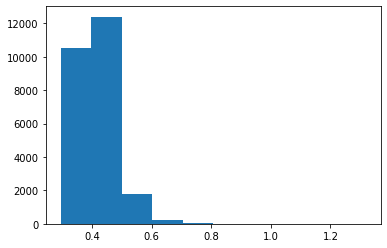

In [48]:
plt.hist(np.sqrt((imdb_array**2).sum(1)));

100 x 20 x 20 x 10 x 2

In [29]:
mlp = nn.Sequential(
    nn.Linear(100, 20),
    nn.Sigmoid(), 
    nn.Linear(20, 20),
    nn.Sigmoid(), 
    nn.Linear(20, 10),
    nn.Sigmoid(), 
    nn.Linear(10, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [30]:
learning_rate = 0.01
num_epochs = 10
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

In [31]:
loss_list = []
acc_list = []
correct_list = []
n_batches = X_train.shape[0]
for epoch in range(num_epochs):
    correct_list = []
    for j in range(n_batches):
        outputs = mlp(X_train[j])
        loss = criterion(outputs, y_train[0][j])#.float())
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = y_train[0][:j].size(0) + 1
        predicted = int(outputs >= 0.5)
        correct_list.append((predicted == y_train[0][j]).item())
        acc_list.append(sum(correct_list) / total)

        if (j + 1) % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, j + 1, n_batches, loss.item(),
                          (sum(correct_list) / total)*100))

/home/lliang06/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [1/10], Step [1000/16750], Loss: 0.7207, Accuracy: 49.00%
Epoch [1/10], Step [2000/16750], Loss: 0.7485, Accuracy: 50.20%
Epoch [1/10], Step [3000/16750], Loss: 0.4242, Accuracy: 55.07%
Epoch [1/10], Step [4000/16750], Loss: 0.1491, Accuracy: 61.78%
Epoch [1/10], Step [5000/16750], Loss: 0.1727, Accuracy: 66.16%
Epoch [1/10], Step [6000/16750], Loss: 0.1363, Accuracy: 69.40%
Epoch [1/10], Step [7000/16750], Loss: 0.1441, Accuracy: 71.93%
Epoch [1/10], Step [8000/16750], Loss: 0.0602, Accuracy: 73.83%
Epoch [1/10], Step [9000/16750], Loss: 1.1032, Accuracy: 75.08%
Epoch [1/10], Step [10000/16750], Loss: 0.0508, Accuracy: 76.32%
Epoch [1/10], Step [11000/16750], Loss: 0.0451, Accuracy: 77.20%
Epoch [1/10], Step [12000/16750], Loss: 0.0607, Accuracy: 77.95%
Epoch [1/10], Step [13000/16750], Loss: 0.2215, Accuracy: 78.58%
Epoch [1/10], Step [14000/16750], Loss: 0.2462, Accuracy: 79.15%
Epoch [1/10], Step [15000/16750], Loss: 0.7169, Accuracy: 79.49%
Epoch [1/10], Step [16000/16750], 

Epoch [9/10], Step [1000/16750], Loss: 1.1605, Accuracy: 90.00%
Epoch [9/10], Step [2000/16750], Loss: 0.4624, Accuracy: 89.25%
Epoch [9/10], Step [3000/16750], Loss: 0.0266, Accuracy: 89.37%
Epoch [9/10], Step [4000/16750], Loss: 0.0153, Accuracy: 89.22%
Epoch [9/10], Step [5000/16750], Loss: 0.0223, Accuracy: 89.06%
Epoch [9/10], Step [6000/16750], Loss: 0.0244, Accuracy: 89.27%
Epoch [9/10], Step [7000/16750], Loss: 0.0356, Accuracy: 89.46%
Epoch [9/10], Step [8000/16750], Loss: 0.1262, Accuracy: 89.54%
Epoch [9/10], Step [9000/16750], Loss: 1.2266, Accuracy: 89.37%
Epoch [9/10], Step [10000/16750], Loss: 0.0215, Accuracy: 89.28%
Epoch [9/10], Step [11000/16750], Loss: 0.0198, Accuracy: 89.09%
Epoch [9/10], Step [12000/16750], Loss: 0.0076, Accuracy: 89.04%
Epoch [9/10], Step [13000/16750], Loss: 0.0232, Accuracy: 88.88%
Epoch [9/10], Step [14000/16750], Loss: 0.0823, Accuracy: 88.77%
Epoch [9/10], Step [15000/16750], Loss: 0.2625, Accuracy: 88.58%
Epoch [9/10], Step [16000/16750], 

In [34]:
torch.save(mlp, './torch_mlp_imdb.pt')

Validating the model (AUC score)

In [32]:
from sklearn.metrics import roc_auc_score

In [33]:
X_test = torch.tensor(np.array([vec for vec in test['w2v'].values])).type('torch.FloatTensor')
y_test = np.array([test['label'].astype(float)]).reshape(8250,)
y_pred = mlp(X_test).t()
roc_auc_score(y_test, y_pred.detach().numpy()[0])

0.9503688380074755

### Given Negative Condition

In [58]:
dim = 100
def model(sentiment):
    emb_mean = torch.zeros(dim)
    emb = pyro.sample('emb', Normal(emb_mean, torch.ones(dim)*10))
    y = pyro.sample('y', Bernoulli(mlp(emb)), obs=sentiment)
    return y

In [61]:
nuts_kernel = NUTS(model, adapt_step_size=True)

In [62]:
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=1000)

In [63]:
mcmc.run(torch.zeros(1))

sample: 100%|██████████| 11000/11000 [3:10:19<00:00,  1.30s/it, step size=6.09e-03, acc. prob=0.834] 


In [65]:
emb_samples_largeVar_GivenNeg = mcmc.get_samples()['emb']

In [66]:
emb_samples_largeVar_GivenNeg.shape

torch.Size([10000, 100])

In [67]:
with open('./imdbeddings_samples_largeVar_GivenNeg.pickle', 'wb') as f:
    pickle.dump(emb_samples_largeVar_GivenNeg, f)

In [68]:
from statsmodels.tsa.tsatools import lagmat

/home/tozeng/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


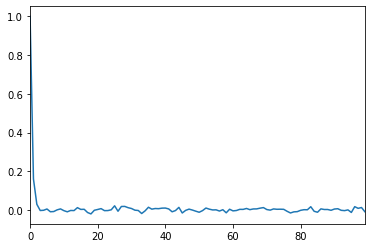

In [69]:
pd.DataFrame(lagmat(emb_samples_largeVar_GivenNeg[:][:, 15], 100, trim='backward')).corr().iloc[0, :].plot()
# plt.savefig("autocorrelation_givenNeg.pdf")

### Validating

In [70]:
from sklearn.decomposition import PCA

In [87]:
negative_sample_pca = PCA(n_components=2)
negative_sample_pca.fit(emb_samples_largeVar_GivenNeg.numpy())

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
negative_pca_projection = negative_sample_pca.transform(emb_samples_largeVar_GivenNeg.numpy())

In [89]:
negative_pca_projection.shape

(10000, 2)

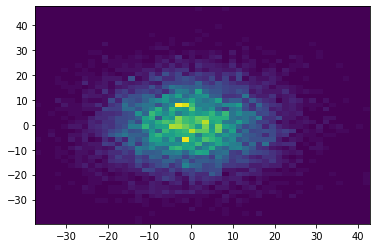

In [90]:
plt.hist2d(x = negative_pca_projection[:, 0], y = negative_pca_projection[:, 1], bins = 50);

### Loading sentiment dictionary


In [91]:
sentiment_df = pd.read_csv('./sentiments.csv')

In [92]:
from scipy.spatial.distance import cdist

In [77]:
sentiment_embedding = {}
sentiment_embedding['word'] = []
sentiment_embedding['sentiment'] = []
sentiment_embedding['embedding'] = []
sentiment_embedding['distances'] = []
for i in range(sentiment_df.shape[0]):
    flag = False
    word = sentiment_df.loc[i]['word']
    try:
        emb = w2v_dict[word]
        flag = True
    except KeyError:
        flag = False
    if flag:
        sentiment_embedding['word'].append(word)
        sentiment_embedding['sentiment'].append(sentiment_df.loc[i]['sentiment'])
        sentiment_embedding['embedding'].append(emb)
        sentiment_embedding['distances'].append(np.mean(cdist(emb_samples_largeVar_GivenNeg.detach().numpy(), emb.reshape(1, -1), metric='cosine')))
    
sentiment_embedding = pd.DataFrame(sentiment_embedding)

In [78]:
sentiment_embedding.sort_values(by='distances')[:10]

,word,sentiment,embedding,distances
3995,dismally,-1,"[-0.23783385753631592, -0.21346889436244965, -...",0.951609
3193,pathetically,-1,"[0.13030953705310822, -0.23664695024490356, -0...",0.957248
2217,substandard,-1,"[0.24860963225364685, -0.19480064511299133, -0...",0.957281
3008,hideously,-1,"[0.18653205037117004, -0.36071667075157166, -0...",0.957371
1182,insultingly,-1,"[0.017356403172016144, -0.3047421872615814, -0...",0.957735
2372,ugh,-1,"[0.024805361405014992, -0.3277624547481537, 0....",0.959048
1520,obnoxiously,-1,"[0.06495609879493713, -0.25265371799468994, 0....",0.959332
2126,squealing,-1,"[0.0036858415696769953, -0.13834598660469055, ...",0.959393
1105,inconsistency,-1,"[0.20494423806667328, -0.06296195089817047, -0...",0.959908
2629,dreadfully,-1,"[-0.03835845738649368, -0.28790631890296936, -...",0.960330


In [79]:
sentiment_embedding.sort_values(by='distances')[-10:]

,word,sentiment,embedding,distances
188,magical,1,"[0.21849659085273743, 0.11799633502960205, -0....",1.031252
1146,infuriated,-1,"[0.18906188011169434, 0.0203684214502573, 0.02...",1.031736
614,supremacy,1,"[-0.022780627012252808, -0.4054063558578491, 0...",1.031983
2989,heartbreaking,-1,"[0.145084947347641, -0.22929060459136963, -0.0...",1.032328
2393,uncompromising,-1,"[0.18212787806987762, 0.09921543300151825, -0....",1.032637
127,invigorating,1,"[-0.048400264233350754, -0.10901805758476257, ...",1.032862
1585,amazing,1,"[0.11927023530006409, 0.12507511675357819, -0....",1.032942
1719,cherished,1,"[-0.16097693145275116, 0.26282617449760437, -0...",1.033271
750,wonderful,1,"[-0.0015268155839294195, 0.18429306149482727, ...",1.033761
693,unforgettable,1,"[0.14442679286003113, 0.3309657871723175, -0.6...",1.037948


In [80]:
sentiment_embedding.sort_values(by='distances')[:10].to_csv('./first10_distances_sentiment_negative.csv')
sentiment_embedding.sort_values(by='distances')[-10:].to_csv('./last10_distances_sentiment_negative.csv')

In [100]:
positive_dict = [] 
for word in sentiment_df[sentiment_df['sentiment'] == 1]['word'].values:
    flag = False
    try:
        emb = w2v_dict[word]
        flag = True
    except KeyError:
        flag = False
    if flag:
        positive_dict.append([np.dot((w2v_dict[word] - negative_sample_pca.mean_), negative_sample_pca.components_[0]), np.dot((w2v_dict[word] - negative_sample_pca.mean_), negative_sample_pca.components_[1])])
        
positive_dict = np.array(positive_dict)

In [101]:
negative_dict = [] 
for word in sentiment_df[sentiment_df['sentiment'] == -1]['word'].values:
    flag = False
    try:
        emb = w2v_dict[word]
        flag = True
    except KeyError:
        flag = False
    if flag:
        negative_dict.append([np.dot((w2v_dict[word] - negative_sample_pca.mean_), negative_sample_pca.components_[0]), np.dot((w2v_dict[word] - negative_sample_pca.mean_), negative_sample_pca.components_[1])])
        
negative_dict = np.array(negative_dict)

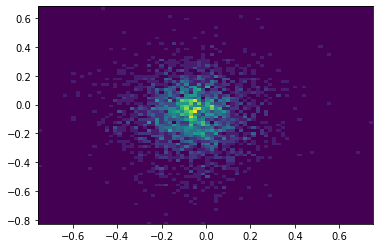

In [102]:
plt.hist2d(x = negative_dict[:, 0], y = negative_dict[:, 1], bins = 80);

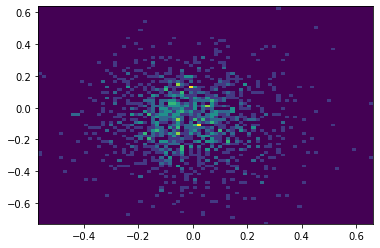

In [103]:
plt.hist2d(x = positive_dict[:, 0], y = positive_dict[:, 1], bins = 80);

In [104]:
from scipy.stats import multivariate_normal

In [106]:
negative_pca_projection.shape

(10000, 2)

In [107]:
from scipy.stats import multivariate_normal

In [108]:
emb_mean_GivenNeg = [np.mean(emb_samples_largeVar_GivenNeg.numpy()[:, i]) for i in range(emb_samples_largeVar_GivenNeg.numpy().shape[1])]
emb_cov_GivenNeg = np.cov([emb_samples_largeVar_GivenNeg.numpy()[:, i] for i in range(emb_samples_largeVar_GivenNeg.numpy().shape[1])])
rv_GivenNeg = multivariate_normal(emb_mean_GivenNeg, emb_cov_GivenNeg)
np.mean([rv_GivenNeg.logpdf(projection) for projection in emb_samples_largeVar_GivenNeg.numpy()])

-371.1514807030814

In [109]:
emb_dictionary_GivenNeg_df = {} 
emb_dictionary_GivenNeg_df['words'] = []
emb_dictionary_GivenNeg_df['sentiment'] = []
emb_dictionary_GivenNeg_df['embeddings'] = []
emb_dictionary_GivenNeg_df['log-likelihood'] = []
for sentiment in sentiment_df.values:
    flag = False
    try:
        emb = w2v_dict[sentiment[0]]
        flag = True
    except KeyError:
        flag = False
    if flag:
        emb_dictionary_GivenNeg_df['words'].append(sentiment[0])
        emb_dictionary_GivenNeg_df['sentiment'].append(sentiment[1])
        emb_dictionary_GivenNeg_df['embeddings'].append(emb)
        emb_dictionary_GivenNeg_df['log-likelihood'].append(rv_GivenNeg.logpdf(emb))
        
emb_dictionary_GivenNeg_df = pd.DataFrame(emb_dictionary_GivenNeg_df)

In [110]:
emb_dictionary_GivenNeg_df.head()

,words,sentiment,embeddings,log-likelihood
0,gratefully,1,"[0.005955322179943323, 0.02346520870923996, -0...",-322.105599
1,gratification,1,"[-0.05209058150649071, -0.3081643581390381, -0...",-322.100586
2,gratifying,1,"[-0.11205840110778809, -0.04113186523318291, -...",-322.164618
3,gratitude,1,"[0.1427360326051712, 0.07226621359586716, 0.12...",-322.140945
4,great,1,"[-0.07837092131376266, 0.13507212698459625, -0...",-322.216625


In [111]:
emb_dictionary_GivenNeg_df.sort_values(by=['log-likelihood'])[['words', 'log-likelihood', 'sentiment']][-20:]

,words,log-likelihood,sentiment
965,bland,-321.955991,-1
1121,inept,-321.955837,-1
3334,redundant,-321.955585,-1
2419,uneventful,-321.952809,-1
1388,mess,-321.950902,-1
1182,insultingly,-321.950830,-1
2281,tedious,-321.949007,-1
1295,lifeless,-321.948612,-1
1179,insult,-321.947652,-1
2601,worthless,-321.947547,-1


In [112]:
emb_dictionary_GivenNeg_df.sort_values(by=['log-likelihood'])[['words', 'log-likelihood', 'sentiment']][:20]

,words,log-likelihood,sentiment
3935,din,-322.343074,-1
2378,ultimatum,-322.340085,-1
693,unforgettable,-322.313937,1
614,supremacy,-322.295272,1
3463,scariest,-322.293876,-1
402,recommended,-322.281609,1
1989,favorite,-322.281243,1
2989,heartbreaking,-322.278727,-1
2923,gritty,-322.278637,-1
1680,breathtaking,-322.278609,1


### Given Positive Condition

In [113]:
dim = 100
def model(sentiment):
    emb_mean = torch.zeros(dim)
    emb = pyro.sample('emb', Normal(emb_mean, torch.ones(dim) * 10))
    y = pyro.sample('y', Bernoulli(mlp(emb)), obs=sentiment)
    return y

In [114]:
Bernoulli(mlp(X_test[0]))

Bernoulli(probs: tensor([0.9806], grad_fn=<SigmoidBackward>))

In [115]:
nuts_kernel = NUTS(model, adapt_step_size=True)

In [116]:
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=1000)

In [117]:
mcmc.run(torch.ones(1))

sample: 100%|██████████| 11000/11000 [1:40:07<00:00,  1.93it/s, step size=2.05e-02, acc. prob=0.719]


In [118]:
emb_samples_largeVar = mcmc.get_samples()['emb']

In [119]:
emb_samples_largeVar.shape

torch.Size([10000, 100])

In [120]:
with open('./imdbeddings_samples_largeVar.pickle', 'wb') as f:
    pickle.dump(emb_samples_largeVar, f)

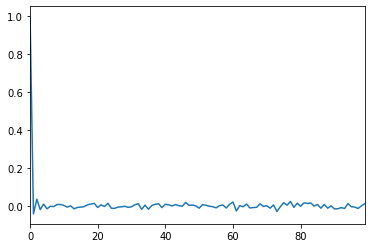

In [122]:
pd.DataFrame(lagmat(emb_samples_largeVar[:][:, 15], 100, trim='backward')).corr().iloc[0, :].plot()
# plt.savefig("autocorrelation_givenNeg.pdf")

In [123]:
sentiment_embedding = {}
sentiment_embedding['word'] = []
sentiment_embedding['sentiment'] = []
sentiment_embedding['embedding'] = []
sentiment_embedding['distances'] = []
for i in range(sentiment_df.shape[0]):
    flag = False
    word = sentiment_df.loc[i]['word']
    try:
        emb = w2v_dict[word]
        flag = True
    except KeyError:
        flag = False
    if flag:
        sentiment_embedding['word'].append(word)
        sentiment_embedding['sentiment'].append(sentiment_df.loc[i]['sentiment'])
        sentiment_embedding['embedding'].append(emb)
        sentiment_embedding['distances'].append(np.mean(cdist(emb_samples_largeVar.detach().numpy(), emb.reshape(1, -1), metric='cosine')))
    
sentiment_embedding = pd.DataFrame(sentiment_embedding)

In [124]:
sentiment_embedding.sort_values(by='distances')[:10]

,word,sentiment,embedding,distances
693,unforgettable,1,"[0.14442679286003113, 0.3309657871723175, -0.6...",0.977411
750,wonderful,1,"[-0.0015268155839294195, 0.18429306149482727, ...",0.978137
1585,amazing,1,"[0.11927023530006409, 0.12507511675357819, -0....",0.978580
1719,cherished,1,"[-0.16097693145275116, 0.26282617449760437, -0...",0.979344
2989,heartbreaking,-1,"[0.145084947347641, -0.22929060459136963, -0.0...",0.979688
127,invigorating,1,"[-0.048400264233350754, -0.10901805758476257, ...",0.980664
614,supremacy,1,"[-0.022780627012252808, -0.4054063558578491, 0...",0.980765
1146,infuriated,-1,"[0.18906188011169434, 0.0203684214502573, 0.02...",0.980860
2393,uncompromising,-1,"[0.18212787806987762, 0.09921543300151825, -0....",0.980898
2044,gem,1,"[0.1499810516834259, -0.1319105476140976, -0.4...",0.981081


In [125]:
sentiment_embedding.sort_values(by='distances')[-10:]

,word,sentiment,embedding,distances
3113,offensively,-1,"[-0.045058559626340866, -0.1381933093070984, -...",1.024082
2126,squealing,-1,"[0.0036858415696769953, -0.13834598660469055, ...",1.025084
1520,obnoxiously,-1,"[0.06495609879493713, -0.25265371799468994, 0....",1.025451
3008,hideously,-1,"[0.18653205037117004, -0.36071667075157166, -0...",1.025688
3193,pathetically,-1,"[0.13030953705310822, -0.23664695024490356, -0...",1.026343
2217,substandard,-1,"[0.24860963225364685, -0.19480064511299133, -0...",1.026813
2372,ugh,-1,"[0.024805361405014992, -0.3277624547481537, 0....",1.026859
2629,dreadfully,-1,"[-0.03835845738649368, -0.28790631890296936, -...",1.026892
1182,insultingly,-1,"[0.017356403172016144, -0.3047421872615814, -0...",1.027150
3995,dismally,-1,"[-0.23783385753631592, -0.21346889436244965, -...",1.030984


In [127]:
emb_mean = [np.mean(emb_samples_largeVar.numpy()[:, i]) for i in range(emb_samples_largeVar.numpy().shape[1])]
emb_cov = np.cov([emb_samples_largeVar.numpy()[:, i] for i in range(emb_samples_largeVar.numpy().shape[1])])
rv = multivariate_normal(emb_mean, emb_cov)
np.mean([rv.logpdf(projection) for projection in emb_samples_largeVar.numpy()])

-371.1756722881468

In [128]:
emb_dictionary_df = {} 
emb_dictionary_df['words'] = []
emb_dictionary_df['sentiment'] = []
emb_dictionary_df['embeddings'] = []
emb_dictionary_df['log-likelihood'] = []
for sentiment in sentiment_df.values:
    flag = False
    try:
        emb = w2v_dict[sentiment[0]]
        flag = True
    except KeyError:
        flag = False
    if flag:
        emb_dictionary_df['words'].append(sentiment[0])
        emb_dictionary_df['sentiment'].append(sentiment[1])
        emb_dictionary_df['embeddings'].append(emb)
        emb_dictionary_df['log-likelihood'].append(rv.logpdf(emb))
        
emb_dictionary_df = pd.DataFrame(emb_dictionary_df)

In [129]:
table0 = pd.DataFrame(emb_dictionary_df.sort_values(by=['log-likelihood'],ascending=False)[['words', 'log-likelihood', 'sentiment']])

In [130]:
table0[:10]

,words,log-likelihood,sentiment
693,unforgettable,-321.405429,1
614,supremacy,-321.414515,1
750,wonderful,-321.416395,1
2989,heartbreaking,-321.418862,-1
2044,gem,-321.420784,1
1585,amazing,-321.421371,1
1816,delightful,-321.424125,1
2393,uncompromising,-321.425067,-1
1719,cherished,-321.425115,1
1989,favorite,-321.425828,1


In [131]:
table0[-10:]

,words,log-likelihood,sentiment
3021,horrid,-321.593497,-1
3268,pretentious,-321.593615,-1
2700,excruciatingly,-321.593787,-1
1093,incoherent,-321.593881,-1
94,indulgent,-321.598907,1
1152,injury,-321.601311,-1
2557,waste,-321.609846,-1
409,redeeming,-321.632039,1
1407,miserably,-321.640916,-1
963,blah,-321.677011,-1


### Validating

In [136]:
from sklearn.decomposition import PCA

In [137]:
positive_sample_pca = PCA(n_components=2)
positive_sample_pca.fit(emb_samples_largeVar.numpy())

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [138]:
positive_pca_projection = positive_sample_pca.transform(emb_samples_largeVar.numpy())

In [139]:
positive_pca_projection.shape

(10000, 2)

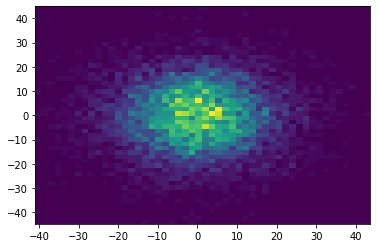

In [140]:
plt.hist2d(x = positive_pca_projection[:, 0], y = positive_pca_projection[:, 1], bins = 50);

In [141]:
positive_dict = [] 
for word in sentiment_df[sentiment_df['sentiment'] == 1]['word'].values:
    flag = False
    try:
        emb = w2v_dict[word]
        flag = True
    except KeyError:
        flag = False
    if flag:
        positive_dict.append([np.dot((w2v_dict[word] - positive_sample_pca.mean_), positive_sample_pca.components_[0]), np.dot((w2v_dict[word] - positive_sample_pca.mean_), positive_sample_pca.components_[1])])
        
positive_dict = np.array(positive_dict)

In [142]:
negative_dict = [] 
for word in sentiment_df[sentiment_df['sentiment'] == -1]['word'].values:
    flag = False
    try:
        emb = w2v_dict[word]
        flag = True
    except KeyError:
        flag = False
    if flag:
        negative_dict.append([np.dot((w2v_dict[word] - positive_sample_pca.mean_), positive_sample_pca.components_[0]), np.dot((w2v_dict[word] - positive_sample_pca.mean_), positive_sample_pca.components_[1])])
        
negative_dict = np.array(negative_dict)

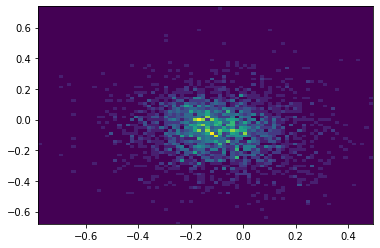

In [143]:
plt.hist2d(x = negative_dict[:, 0], y = negative_dict[:, 1], bins = 80);

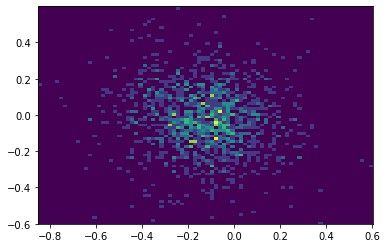

In [144]:
plt.hist2d(x = positive_dict[:, 0], y = positive_dict[:, 1], bins = 80);

### Loading the EEC dataset

In [145]:
eec_df = pd.read_csv('./Equity-Evaluation-Corpus.csv')

In [146]:
eec_df.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


In [147]:
spark_eec = spark.read.format("csv").options(header="true").load("./Equity-Evaluation-Corpus.csv")

In [149]:
Names = np.unique(eec_df['Person'].values)
Gender = np.unique(eec_df['Gender'].values)
Race = np.unique([race for race in eec_df['Race'].values if race != None])
Emotion = np.unique([emo for emo in eec_df['Emotion'].values if emo != None])
Emotion_word = np.unique([emo for emo in eec_df['Emotion word'].values if emo != None])

In [150]:
eec2vec = sentence2vec.transform(spark_eec.select(fn.col('Sentence').alias('review'), 'Person', 'Gender', 'Race', 'Emotion'))

In [151]:
eec2vec = eec2vec.toPandas()

In [152]:
for i in range(eec2vec.shape[0]):
    eec2vec.loc[i]['w2v'] = eec2vec.loc[i]['w2v'].values

In [153]:
eec2vec.head()

,review,Person,Gender,Race,Emotion,words,w2v
0,Alonzo feels angry.,Alonzo,male,African-American,anger,"[alonzo, feels, angry]","[-0.019689195478955902, -0.060500080386797585,..."
1,Alonzo feels furious.,Alonzo,male,African-American,anger,"[alonzo, feels, furious]","[-0.014902535205086071, -0.12798841297626495, ..."
2,Alonzo feels irritated.,Alonzo,male,African-American,anger,"[alonzo, feels, irritated]","[-0.04984642130633195, -0.14080162346363068, -..."
3,Alonzo feels enraged.,Alonzo,male,African-American,anger,"[alonzo, feels, enraged]","[0.014770370597640673, -0.03619461258252461, -..."
4,Alonzo feels annoyed.,Alonzo,male,African-American,anger,"[alonzo, feels, annoyed]","[-0.06823695761462052, -0.0657951682806015, -0..."


In [154]:
def get_eec(person = False, gender = False, race = False, emotion = False, word = False):
    flag = False
    if person != False:
        df = eec2vec[eec2vec['Person'] == person]
        flag = True
    if gender != False:
        if flag != False:
            df = df[df['Gender'] == gender]
        else:
            df = eec2vec[eec2vec['Gender'] == gender]
            flag = True
    if race != False:
        if flag != False:
            df = df[df['Race'] == race]
        else:
            df = eec2vec[eec2vec['Race'] == race]
            flag = True
    if emotion != False:
        if flag != False:
            df = df[df['Emotion'] == emotion]
        else:
            df = eec2vec[eec2vec['Emotion'] == emotion]
            flag = True
    if word != False:
        if flag != False:
            df = df[df['Emotion word'] == word]
        else:
            df = eec2vec[eec2vec['Emotion word'] == word]
            flag = True
    if (person == False) & (gender == False) & (race == False) & (emotion == False) & (word == False):
        return eec2vec['w2v']
    return df['w2v']

In [155]:
import ast

In [156]:
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [157]:
eec2vec.to_csv('./eec2vec.csv')

In [158]:
male_names = [name.lower() for name in np.unique(eec[eec['Gender'] == 'male']['Person'].values)]

In [160]:
female_names = [name.lower() for name in np.unique(eec[eec['Gender'] == 'female']['Person'].values)]

In [161]:
gender_distances_df = {}
gender_distances_df['name'] = []
gender_distances_df['gender'] = []
gender_distances_df['embeddings'] = []
gender_distances_df['distances_GivenPos'] = []
gender_distances_df['distances_GivenNeg'] = []
for man in male_names:
    flag = False
    try:
        emb = w2v_dict[man]
        flag = True
    except KeyError:
        flag = False
    if flag:
        gender_distances_df['gender'].append(1.0)
        gender_distances_df['name'].append(man)
        gender_distances_df['embeddings'].append(emb)
        gender_distances_df['distances_GivenPos'].append(np.mean(cdist(emb_samples_largeVar.detach().numpy(), emb.reshape(1, -1), metric='cosine')))
        gender_distances_df['distances_GivenNeg'].append(np.mean(cdist(emb_samples_largeVar_GivenNeg.detach().numpy(), emb.reshape(1, -1), metric='cosine')))
    
for woman in female_names:
    flag = False
    try:
        emb = w2v_dict[woman]
        flag = True
    except KeyError:
        flag = False
    if flag:
        gender_distances_df['gender'].append(-1.0)
        gender_distances_df['name'].append(woman)
        gender_distances_df['embeddings'].append(emb)
        gender_distances_df['distances_GivenPos'].append(np.mean(cdist(emb_samples_largeVar.detach().numpy(), emb.reshape(1, -1), metric='cosine')))
        gender_distances_df['distances_GivenNeg'].append(np.mean(cdist(emb_samples_largeVar_GivenNeg.detach().numpy(), emb.reshape(1, -1), metric='cosine')))

gender_distances_df = pd.DataFrame(gender_distances_df)

In [162]:
gender_distances_df.head()

,name,gender,embeddings,distances_GivenPos,distances_GivenNeg
0,adam,1.0,"[-0.6852840185165405, 0.03809604048728943, 0.1...",0.997957,1.002851
1,alan,1.0,"[-0.14613071084022522, 0.14654093980789185, -0...",0.999164,0.999940
2,alonzo,1.0,"[0.026881061494350433, 0.1803232878446579, -0....",0.997503,1.002716
3,alphonse,1.0,"[0.10859247297048569, 0.17322281002998352, -0....",0.993351,1.008537
4,andrew,1.0,"[-0.37180769443511963, 0.042230330407619476, -...",0.998472,1.002787


In [163]:
gender_distances_df.groupby(['gender']).mean()

,distances_GivenPos,distances_GivenNeg
gender,,
-1.0,1.001747,0.997181
1.0,0.998778,1.001024
